https://archive.ics.uci.edu/dataset/529/early+stage+diabetes+risk+prediction+dataset

#### Early stage diabetes risk prediction

In [1]:
%load_ext autoreload

# Import packages
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt

from matplotlib import colormaps
from time import time

from GeneralFunctions import *
from Q1 import *


Data processing functions.

In [2]:
# Load in the data
save = False

filepath = './heart_failure_clinical_records_dataset.csv'
x, y = ReadHeartFailureData(filepath)
y = np.ravel(y)

Querry By Committee

In [3]:
#QBC
%autoreload 2

n_sims = 10

start = time()
processes = []
parent_connectors = []

for i in range(n_sims):
    parent, child = mp.Pipe(duplex = False)
    p = mp.Process(target = SimulateAL_MP, args = (x.copy(), y.copy(), 'QBC', i*2024, child))
    processes.append(p)
    parent_connectors.append(parent)

for process in processes:
    process.start()
    
all_acc, all_loss = [], []
for parent in parent_connectors:
    res = parent.recv()
    all_acc.append(res[0])
    all_loss.append(res[1])

for process in processes:
    process.join()
end = time()
minutes, seconds = divmod(end - start, 60)
print(f'Processes take {minutes:0>2.0f}m:{seconds:0>2.0f}s')

Processes take 00m:41s


In [4]:
if save:
    np.save('./results/QBC_accuracy.npy', all_acc)
    np.save('./results/QBC_loss.npy', all_loss)

Minimizing Expected Risk

In [5]:
# Minimize Expected Risk
n_sims = 10

start = time()
processes = []
parent_connectors = []

for i in range(n_sims):
    parent, child = mp.Pipe(duplex = False)
    p = mp.Process(target = SimulateAL_MP, args = (x.copy(), y.copy(), 'ERM', i*2024, child))
    processes.append(p)
    parent_connectors.append(parent)

for process in processes:
    process.start()
    
all_acc, all_loss = [], []
for parent in parent_connectors:
    res = parent.recv()
    all_acc.append(res[0])
    all_loss.append(res[1])

for process in processes:
    process.join()
end = time()
minutes, seconds = divmod(end - start, 60)
print(f'Processes took {minutes:0>2.0f}m:{seconds:0>2.0f}s')

Processes took 02m:23s


In [6]:
if save:
    np.save('./results/ERM_accuracy.npy', all_acc)
    np.save('./results/ERM_loss.npy', all_loss)

Density Based Sampling

In [7]:
# Minimize Expected Risk
# n_sims = 10

# start = time()
# processes = []
# parent_connectors = []

# for i in range(n_sims):
#     parent, child = mp.Pipe(duplex = False)
#     p = mp.Process(target = SimulateAL_MP, args = (x.copy(), y.copy(), 'DBS', i*2024, child))
#     processes.append(p)
#     parent_connectors.append(parent)

# for process in processes:
#     process.start()
    
# all_acc, all_loss = [], []
# for parent in parent_connectors:
#     res = parent.recv()
#     all_acc.append(res[0])
#     all_loss.append(res[1])

# for process in processes:
#     process.join()
# end = time()
# minutes, seconds = divmod(end - start, 60)
# print(f'Processes took {minutes:0>2.0f}m:{seconds:0>2.0f}s')

In [8]:
n_sims = 10

start = time()
with mp.Pool(mp.cpu_count()-1) as p:
    args = [(x.copy(), y.copy(), 'DBS', i*2024) for i in range(n_sims)]
    async_res = p.starmap_async(SimulateAL_MP, args)
    async_res.wait()
    results = async_res.get()

all_acc = [res[0] for res in results]
all_loss = [res[1] for res in results]

end = time()
minutes, seconds = divmod(end - start, 60)
print(f'Processes took {minutes:0>2.0f}m:{seconds:0>2.0f}s')

Processes took 00m:44s


In [9]:
if save:
    np.save('./results/DBS_accuracy.npy', all_acc)
    np.save('./results/DBS_loss.npy', all_loss)

Uncertainty Sampling

In [10]:
# Uncertainty Sampling
n_sims = 10
start = time()
with mp.Pool(mp.cpu_count()-1) as p:
    args = [(x.copy(), y.copy(), 'US', i*2024) for i in range(n_sims)]
    async_res = p.starmap_async(SimulateAL_MP, args)
    async_res.wait()
    results = async_res.get()

all_acc = [res[0] for res in results]
all_loss = [res[1] for res in results]

end = time()
minutes, seconds = divmod(end - start, 60)
print(f'Processes took {minutes:0>2.0f}m:{seconds:0>2.0f}s')

Processes took 00m:08s


In [11]:
if save:
    np.save('./results/US_accuracy.npy', all_acc)
    np.save('./results/US_loss.npy', all_loss)

Passive Learning

In [12]:
from functools import partial
n_sims = 10
start = time()
with mp.Pool(mp.cpu_count()-1) as p:
    args = [(x.copy(), y.copy(), 'rand', i*2024) for i in range(n_sims)]
    async_res = p.starmap_async(partial(SimulateAL_MP), args)
    async_res.wait()
    results = async_res.get()

all_acc = [res[0] for res in results]
all_loss = [res[1] for res in results]

end = time()
minutes, seconds = divmod(end - start, 60)
print(f'Processes took {minutes:0>2.0f}m:{seconds:0>2.0f}s')

Processes took 00m:08s


In [13]:
if save:
    np.save('./results/PL_accuracy.npy', all_acc)
    np.save('./results/PL_loss.npy', all_loss)

#### Plotting

In [14]:
def LinePlotWithErrors(x, y, err_y, label, fig = None, ax = None, color = None):
    """
    Plots a line with error bars
    """
    if ax is None:
        fig, ax = plt.subplots(1)
        ax.set_prop_cycle(color=colormaps.get_cmap('Accent').colors)
    else:
        assert fig is not None, "You must pass in the figure object if you pass in the axis object"

    if color is None:
        handle, = ax.plot(x, y, label = label) 
        color = handle.get_color()
    else:
        handle, = ax.plot(x, y, label = label, color = color)
    ax.errorbar(x,y,err_y, alpha = 0.1, capsize = 5, ecolor = color)
    
    return fig, ax

def PreparePlotData(acc, loss):
    """
    Prepare the accuracy and loss data for plotting.
    Input:
    acc, loss (np.ndarray): numpy arrays of the shape (n_simulations x n_iteration)
        where n_iterations is the number of iterations in a single simulation 
    
    Output:
        avg accuracy, std of accuracy, avg loss, std of loss accross the n simulations
    """
    acc_y = np.mean(acc, axis = 0)
    acc_err = np.std(acc, axis = 0)
    loss_y = np.mean(loss, axis = 0)
    loss_err = np.std(loss, axis = 0)

    return acc_y, acc_err, loss_y, loss_err

In [15]:
methods = ['QBC', 'ERM', 'DBS', 'US', 'PL']

accuracies, accuracies_err, losses, losses_err, plot_x = [], [], [], [], []

for method in methods:
    acc = np.load('./results/'+method+'_accuracy.npy')
    loss= np.load('./results/'+method+'_loss.npy')

    acc_y, acc_err, loss_y, loss_err = PreparePlotData(acc, loss)
    n_iters = acc_y.shape[0]
    plot_x.append(np.arange(n_iters) + n_iters//4)
    accuracies.append(acc_y)
    accuracies_err.append(acc_err)
    losses.append(loss_y)
    losses_err.append(loss_err)


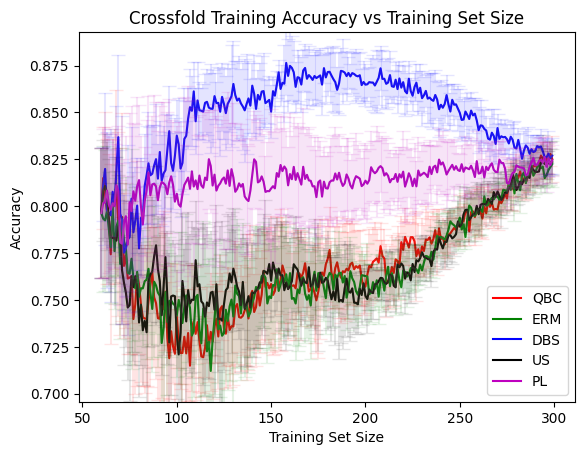

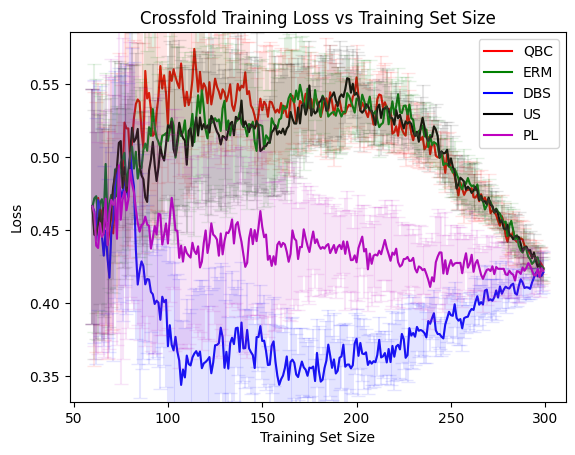

In [16]:
colors = ['r', 'g', 'b', 'k', 'm']

for i in range(len(accuracies)):
    if i == 0:
        fig1, ax1 = LinePlotWithErrors(plot_x[i], accuracies[i], accuracies_err[i], methods[i], color = colors[i])
        fig2, ax2 = LinePlotWithErrors(plot_x[i], losses[i], losses_err[i], methods[i], color = colors[i])
    else:
        fig1, ax1 = LinePlotWithErrors(plot_x[i], accuracies[i], accuracies_err[i], methods[i], fig= fig1, ax = ax1, color = colors[i])
        fig2, ax2 = LinePlotWithErrors(plot_x[i], losses[i], losses_err[i], methods[i], fig= fig2, ax = ax2, color = colors[i])


y_max = np.max(np.concatenate(accuracies))
y_min = np.min(np.concatenate(accuracies))
ax1.set_title('Crossfold Training Accuracy vs Training Set Size')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(y_min-0.1*(y_max - y_min), y_max+0.1*(y_max - y_min))
ax1.legend()

y_max = np.max(np.concatenate(losses))
y_min = np.min(np.concatenate(losses))
ax2.set_title('Crossfold Training Loss vs Training Set Size')
ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Loss')
ax2.set_ylim(y_min-0.05*(y_max - y_min), y_max+0.05*(y_max - y_min))
ax2.legend()

plt.show(fig1, fig2)
plt.close(fig1)
plt.close(fig2)